In [13]:
import pandas as pd 
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
import warnings

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow 


import scipy
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


# Set the seed value for experiment reproduci.bility.
seed = 1453
tensorflow.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')

Num GPUs Available:  1


In [14]:
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     


train_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train',
                                                 shuffle=True,
                                                 target_size=(256,256), 
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid',
                                                 shuffle=True,
                                                 target_size=(256,256), 
                                                 class_mode='categorical')

image_generator_submission = ImageDataGenerator(rescale=1/255) 
submission = image_generator_submission.flow_from_directory(
                                                 directory='../input/new-plant-diseases-dataset/test/',
                                                 shuffle=False,
                                                 target_size=(256,256), 
                                                 class_mode=None)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Found 33 images belonging to 1 classes.


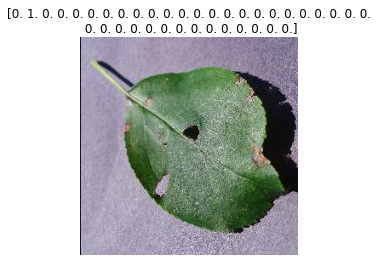

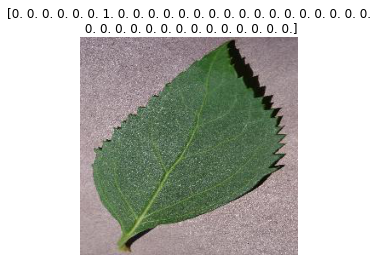

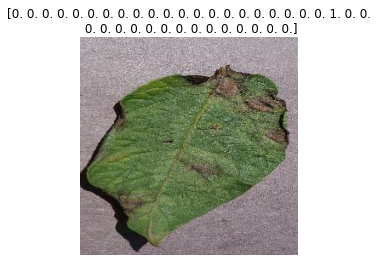

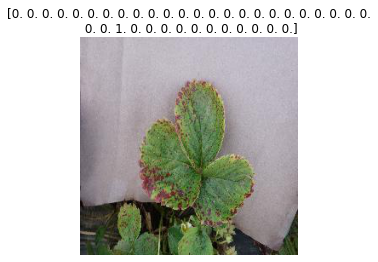

In [15]:
batch_1_img = train_dataset[0]
for i in range(0,4):
    img = batch_1_img[0][i]
    lab = batch_1_img[1][i]
    plt.imshow(img)
    plt.title(lab)
    plt.axis('off')
    plt.show()

In [20]:
model = keras.models.Sequential([
keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = [256,256,3]),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(32, (2, 2), activation='relu'),
keras.layers.MaxPooling2D(),

keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),

keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.Flatten(),

keras.layers.Dense(512, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.7),

keras.layers.Dense(128, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

keras.layers.Dense(64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.3),

keras.layers.Dense(38, activation ='softmax')])


In [21]:
model.compile(
        optimizer='adam',
        loss=tensorflow.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.AUC(name='auc'),'acc']
    )

In [22]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = keras.callbacks.ModelCheckpoint("plant_model.h5",
                                                    monitor='val_acc',
                                                    save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_acc',patience=10,restore_best_weights=True)

In [23]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=200
)

Epoch 1/200
8787/8787 [==============================] - 618s 70ms/step - loss: 2.9518 - auc: 0.8130 - acc: 0.1680 - val_loss: 3.9178 - val_auc: 0.7683 - val_acc: 0.1503
Epoch 2/200
8787/8787 [==============================] - 304s 35ms/step - loss: 2.6191 - auc: 0.8658 - acc: 0.2414 - val_loss: 9.3059 - val_auc: 0.5524 - val_acc: 0.0731
Epoch 3/200
8787/8787 [==============================] - 304s 35ms/step - loss: 2.4913 - auc: 0.8809 - acc: 0.2757 - val_loss: 37.4990 - val_auc: 0.9096 - val_acc: 0.3606
Epoch 4/200
8787/8787 [==============================] - 306s 35ms/step - loss: 2.3099 - auc: 0.9003 - acc: 0.3231 - val_loss: 8.5854 - val_auc: 0.9219 - val_acc: 0.3994
Epoch 5/200
8787/8787 [==============================] - 308s 35ms/step - loss: 2.2811 - auc: 0.9026 - acc: 0.3294 - val_loss: 88601416.0000 - val_auc: 0.9292 - val_acc: 0.4559
Epoch 6/200
8787/8787 [==============================] - 310s 35ms/step - loss: 2.0565 - auc: 0.9225 - acc: 0.3855 - val_loss: 28582.2461 - va

In [24]:
from tensorflow.keras.models import load_model

model=load_model('plant_model.h5')

In [25]:
model.evaluate(validation_dataset)

2197/2197 [==============================] - 63s 29ms/step - loss: 6952635.5000 - auc: 0.9892 - acc: 0.9004


[6952635.5, 0.9892067313194275, 0.9003528356552124]

In [27]:
pred=model.predict(submission[0])

y_pred=pd.DataFrame(np.argmax(pred,axis=1),columns=['Label'])

In [41]:
l=[]
for i in train_dataset.filenames:
    if l.count(i.split('/')[0])==0:
        l.append(i.split('/')[0])


In [44]:
names=[]
for i in submission.filenames:
    names.append(i.split('/')[1].replace('.JPG',''))

In [49]:
list(enumerate(l))

[(0, 'Apple___Apple_scab'),
 (1, 'Apple___Black_rot'),
 (2, 'Apple___Cedar_apple_rust'),
 (3, 'Apple___healthy'),
 (4, 'Blueberry___healthy'),
 (5, 'Cherry_(including_sour)___Powdery_mildew'),
 (6, 'Cherry_(including_sour)___healthy'),
 (7, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'),
 (8, 'Corn_(maize)___Common_rust_'),
 (9, 'Corn_(maize)___Northern_Leaf_Blight'),
 (10, 'Corn_(maize)___healthy'),
 (11, 'Grape___Black_rot'),
 (12, 'Grape___Esca_(Black_Measles)'),
 (13, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'),
 (14, 'Grape___healthy'),
 (15, 'Orange___Haunglongbing_(Citrus_greening)'),
 (16, 'Peach___Bacterial_spot'),
 (17, 'Peach___healthy'),
 (18, 'Pepper,_bell___Bacterial_spot'),
 (19, 'Pepper,_bell___healthy'),
 (20, 'Potato___Early_blight'),
 (21, 'Potato___Late_blight'),
 (22, 'Potato___healthy'),
 (23, 'Raspberry___healthy'),
 (24, 'Soybean___healthy'),
 (25, 'Squash___Powdery_mildew'),
 (26, 'Strawberry___Leaf_scorch'),
 (27, 'Strawberry___healthy'),
 (28, 'Tomat

In [60]:
pd.concat([y_pred,pd.DataFrame(names,columns=['names'])],axis=1)

,Label,names
0,2.0,AppleCedarRust1
1,2.0,AppleCedarRust2
2,2.0,AppleCedarRust3
3,2.0,AppleCedarRust4
4,0.0,AppleScab1
5,31.0,AppleScab2
6,7.0,AppleScab3
7,8.0,CornCommonRust1
8,8.0,CornCommonRust2
9,8.0,CornCommonRust3


In [28]:
y_pred

,Label
0,2
1,2
2,2
3,2
4,0
5,31
6,7
7,8
8,8
9,8


In [ ]:
pred=model.predict(submission[0])
pred

In [ ]:
max(pred[1])

In [ ]:
pred[1]

In [ ]:
submission.labels